In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import multivariate_normal as mnorm
from scipy.stats import kde
from tqdm import tqdm_notebook
from scipy.optimize import minimize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

## синтезирую задачу

In [4]:
x_class0 = np.random.randn(5000, 2)*np.array([2, 3])+np.array([5, 5])

In [5]:
x_class1 = np.random.randn(5000, 2)*np.array([3, 2])+np.array([5, -5])

In [6]:
x_class2 = np.random.randn(5000, 2)*np.array([2, 3])+np.array([-5, -5])

In [7]:
x_class3 = np.random.randn(5000, 2)*np.array([3, 2])+np.array([-5, 5])

In [8]:
nbins = 300
xmesh, ymesh = np.mgrid[-15:15:nbins*1j, -15:15:nbins*1j]

In [9]:
rv = mnorm([5, 5], [[2.0, 0.0], [0.0, 3.0]])
norm_class0 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [10]:
rv = mnorm([5, -5], [[3.0, 0.0], [0.0, 2.0]])
norm_class1 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [11]:
rv = mnorm([-5, -5], [[2.0, 0.0], [0.0, 3.0]])
norm_class2 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [12]:
rv = mnorm([-5, 5], [[3.0, 0.0], [0.0, 2.0]])
norm_class3 = rv.pdf(np.concatenate([xmesh[:,:,np.newaxis], ymesh[:,:,np.newaxis]], axis=-1))

In [13]:
y = np.squeeze(np.concatenate([np.zeros((5000,1), dtype=int),
                               np.ones((5000,1), dtype=int),
                               np.ones((5000,1), dtype=int)*2,
                               np.ones((5000,1), dtype=int)*3],
                              axis=0))

In [14]:
x = np.concatenate([x_class0, x_class1, x_class2, x_class3], axis=0)
x.shape

(20000, 2)

In [15]:
colors = {0: 'red', 1: 'green', 2: 'blue', 3: 'gray'}

In [16]:
cmaps = ['Reds', 'Greens', 'Blues', 'Greys']

In [17]:
clabels = [colors[l] for l in y]

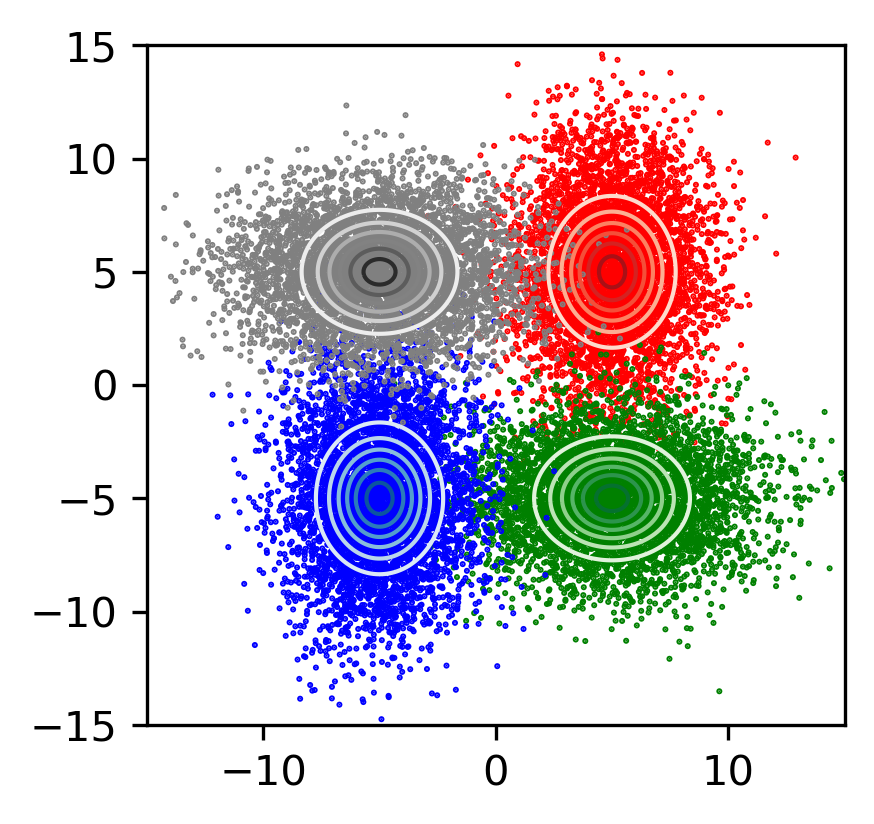

In [18]:
f = plt.figure(figsize=(3,3), dpi=300)
plt.scatter(x[:,0], x[:,1], s=0.2, c=clabels)
for class_label,norm in zip([0,1,2,3],
                            [norm_class0, norm_class1, norm_class2, norm_class3]):
    _ = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)

## Посмотрим, как работает линейный SVM

In [19]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2)

In [20]:
model = SVC(kernel='linear', probability=True)

In [21]:
model.fit(xtrain, ytrain);

In [22]:
train_pred_sk = model.predict(xtrain)
train_proba_sk = model.predict_proba(xtrain)

In [23]:
(train_pred_sk == ytrain).mean()

0.955

Применим на тестовой выборке и проверим оценку качества

In [24]:
test_pred_sk = model.predict(xtest)
test_proba_sk = model.predict_proba(xtest)

In [25]:
(test_pred_sk == ytest).mean()

0.95575

Интересное наблюдение: модель показывает практически неразличимое качество на тренировочной и тестовой выборках. Это еще нужно аккуратно проверить построением доверительных интервалов (например, с использованием подхода Bootstrap).

### Отобразим оценки вероятностей в пространстве признаков

In [26]:
x_test_mesh = np.concatenate([xmesh.ravel()[:,np.newaxis], ymesh.ravel()[:,np.newaxis]], axis=-1)
x_test_mesh.shape

(90000, 2)

In [27]:
labels_mesh = model.predict(x_test_mesh)
probas_mesh = model.predict_proba(x_test_mesh)

In [28]:
labels_mesh = labels_mesh.reshape(xmesh.shape)
probas_mesh = probas_mesh.reshape(list(xmesh.shape) + [4])

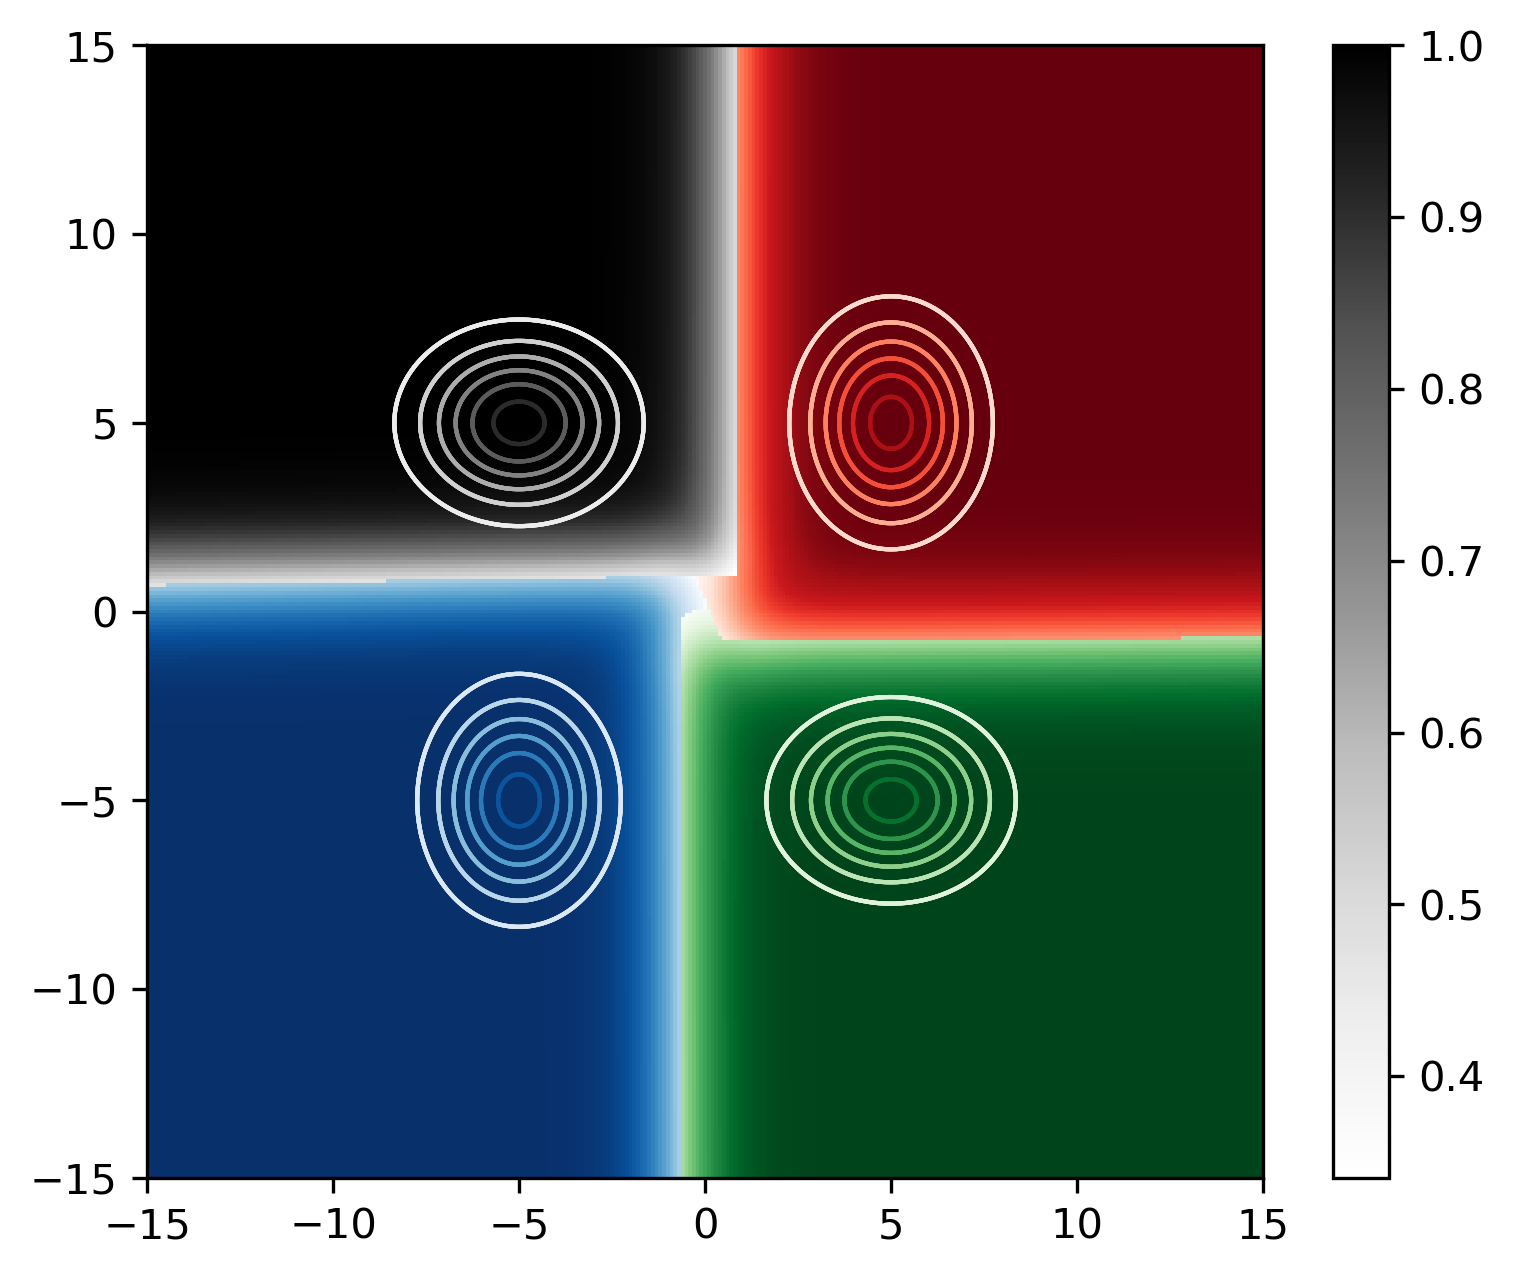

In [31]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)
for class_label,proba_mesh in zip([0,1,2,3],
                                  [probas_mesh[:,:,0], probas_mesh[:,:,1], probas_mesh[:,:,2], probas_mesh[:,:,3]]):
    pm = np.ma.array(proba_mesh)
    pm.mask = (labels_mesh != class_label)
    pcolormeshplot = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label])
    for class_label,norm in zip([0,1,2,3], [norm_class0, norm_class1, norm_class2, norm_class3]):
        cplot = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
plt.colorbar(pcolormeshplot)

Интересное наблюдение: у линейного SVM без преобразования признаков и без применения kernel trick разделяющие гиперповерхности кусочно линейны.

### Отобразим вероятности классов в некоторых интересных сечениях

In [32]:
p0 = np.array([5, 5])
p1 = np.array([5, -5])
linspace = np.array([p0+k*((p1-p0)/100) for k in np.linspace(-50, 150, 500)])
linspace.shape

(500, 2)

In [35]:
probas_linspace = model.predict_proba(linspace)

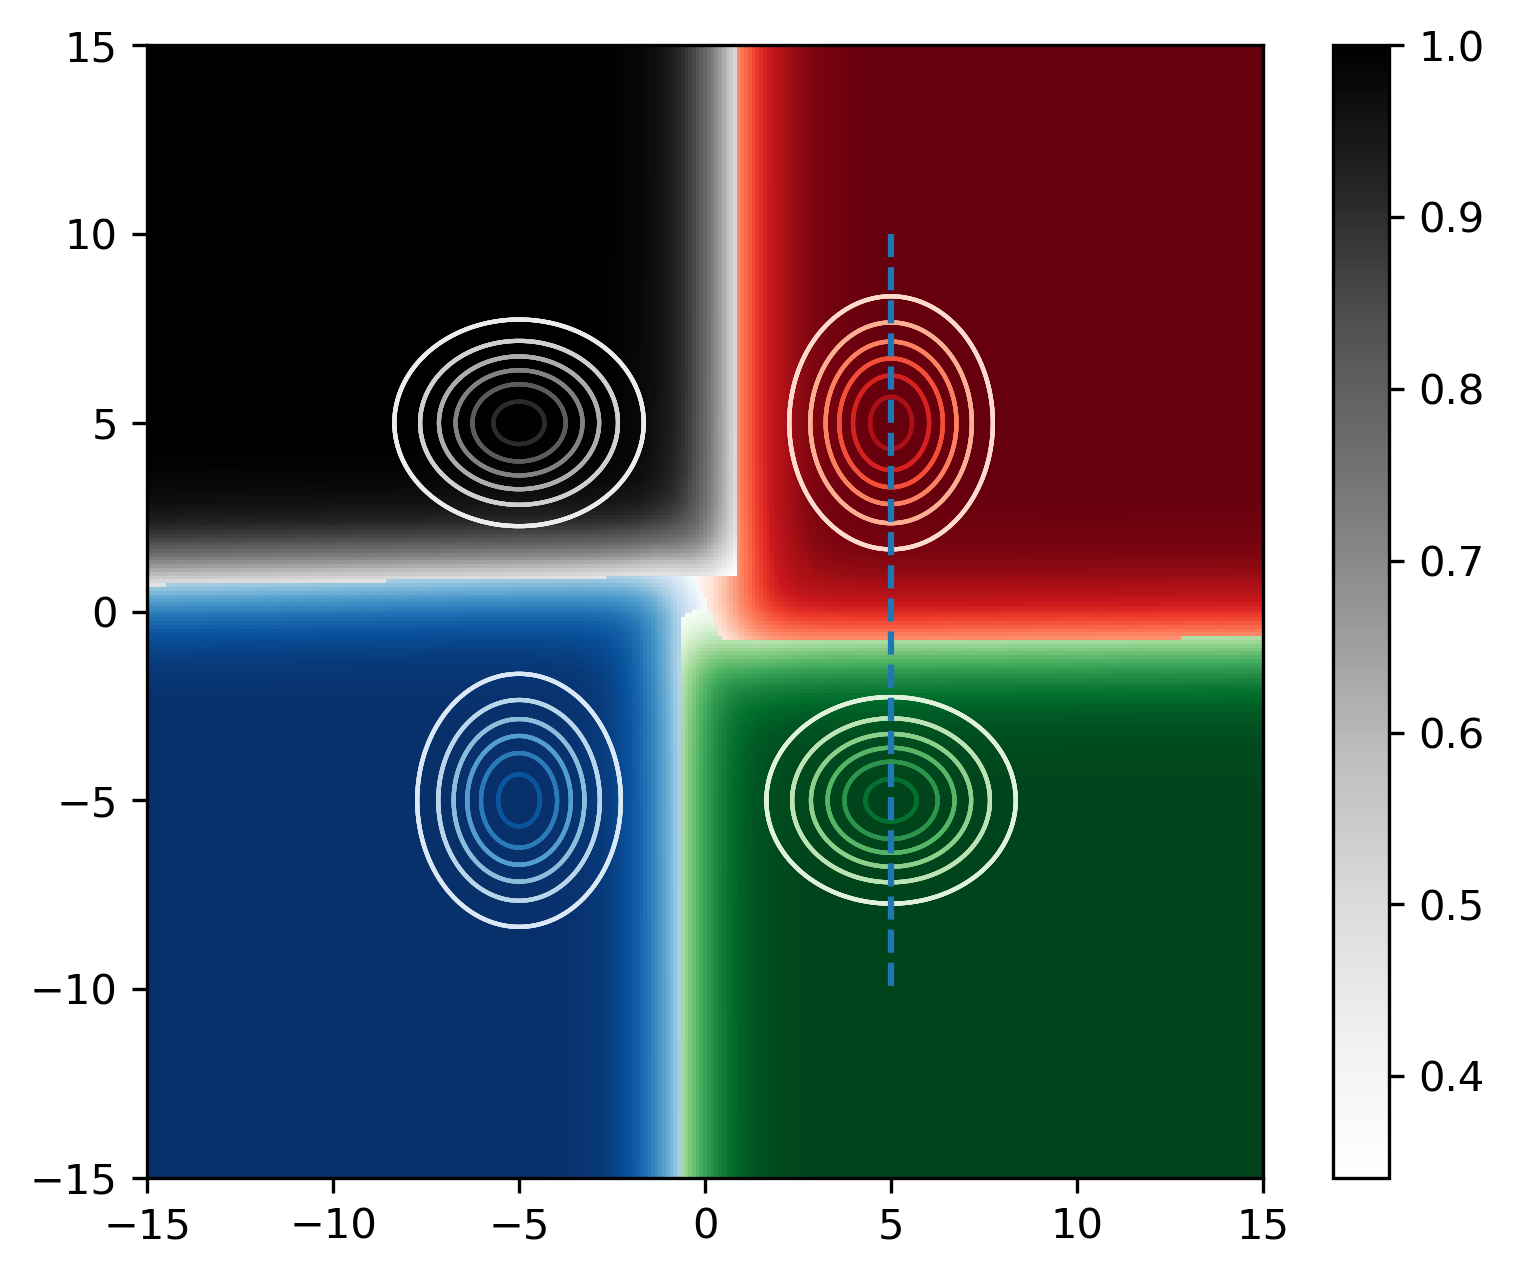

In [37]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)
for class_label,proba_mesh in zip([0,1,2,3],
                                  [probas_mesh[:,:,0], probas_mesh[:,:,1], probas_mesh[:,:,2], probas_mesh[:,:,3]]):
    pm = np.ma.array(proba_mesh)
    pm.mask = (labels_mesh != class_label)
    pcolormeshplot = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label])
    for class_label,norm in zip([0,1,2,3], [norm_class0, norm_class1, norm_class2, norm_class3]):
        cplot = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
_ = plt.plot(linspace[:,0], linspace[:,1], '--')

plt.colorbar(pcolormeshplot)

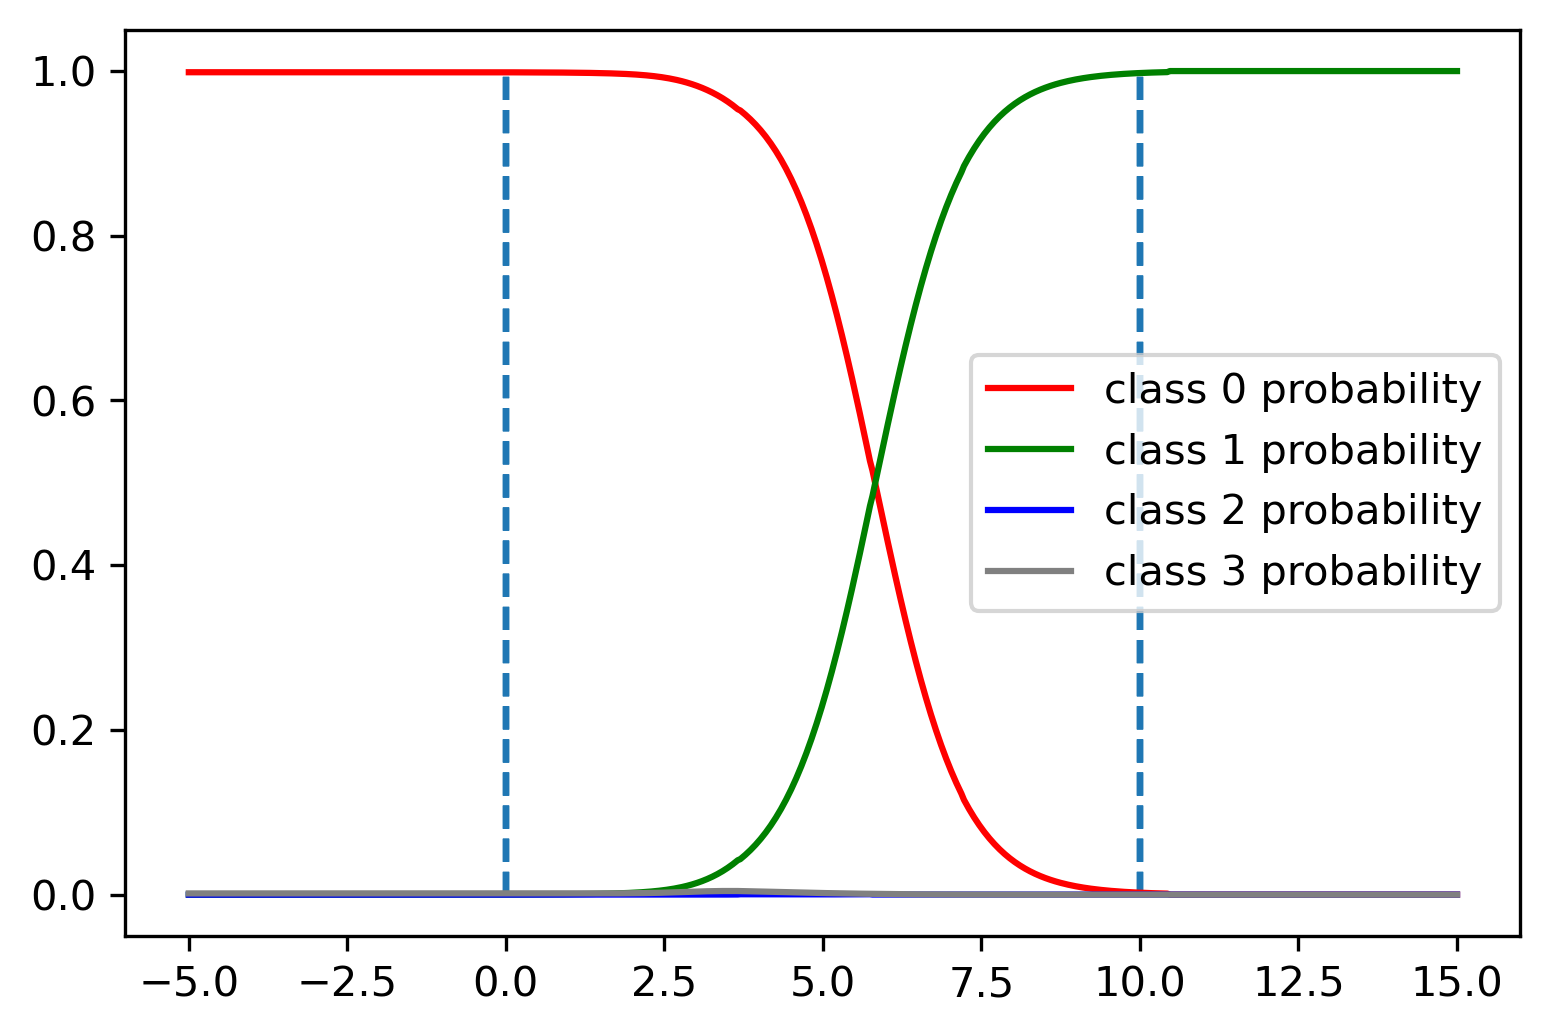

In [38]:
_ = plt.figure(figsize=(6,4), dpi=300)

for class_label,proba in zip([0,1,2,3],
                             [probas_linspace[:,0], probas_linspace[:,1], probas_linspace[:,2], probas_linspace[:,3]]):
    
    _ = plt.plot(np.linalg.norm(linspace-p0, axis=-1)*np.sign(np.dot((linspace-p0), (p1-p0))),
                 proba, color=colors[class_label],
                 label='class %d probability' % class_label)
    _ = plt.vlines([0.0, np.linalg.norm(p1-p0)],
                   0.0, 1.0, linestyles='dashed')
plt.legend()

In [39]:
p0 = np.array([5, 5])
p1 = np.array([-5, -5])
linspace = np.array([p0+k*((p1-p0)/100) for k in np.linspace(-50, 150, 500)])
linspace.shape

(500, 2)

In [40]:
probas_linspace = model.predict_proba(linspace)

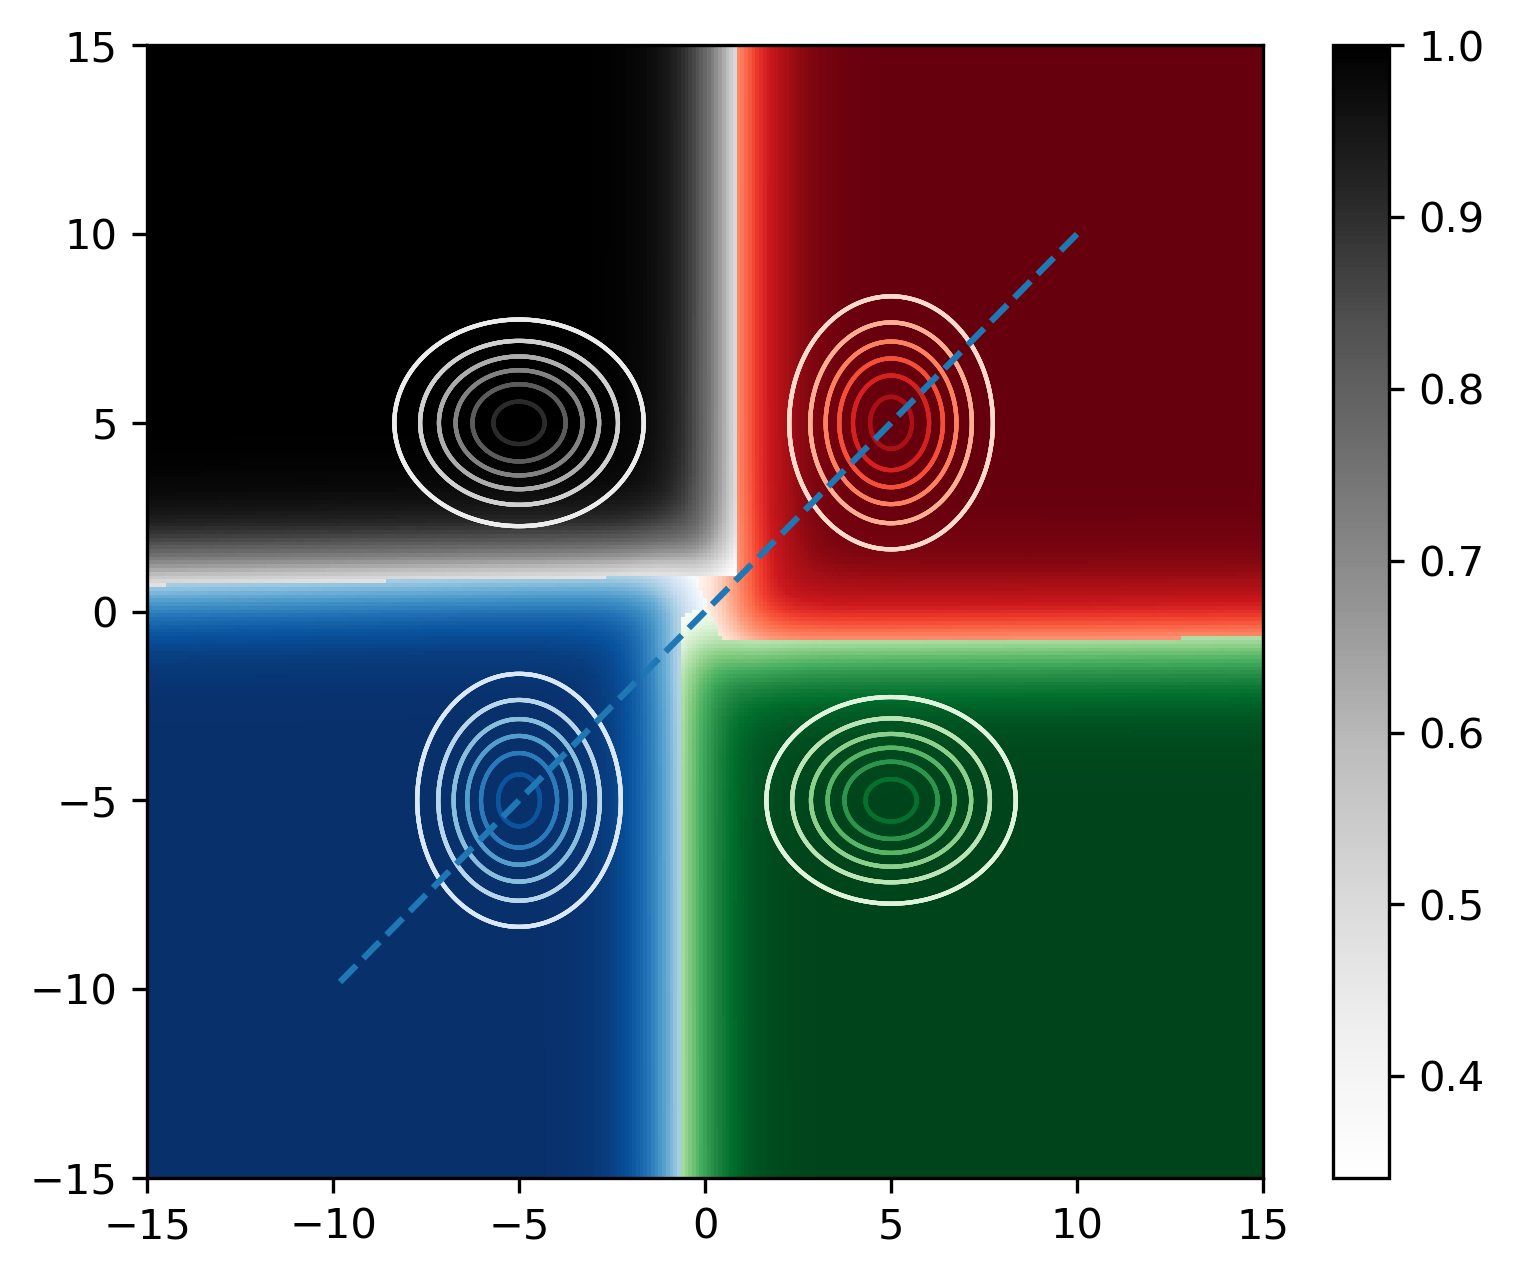

In [41]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)
for class_label,proba_mesh in zip([0,1,2,3],
                                  [probas_mesh[:,:,0], probas_mesh[:,:,1], probas_mesh[:,:,2], probas_mesh[:,:,3]]):
    pm = np.ma.array(proba_mesh)
    pm.mask = (labels_mesh != class_label)
    pcolormeshplot = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label])
    for class_label,norm in zip([0,1,2,3], [norm_class0, norm_class1, norm_class2, norm_class3]):
        cplot = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
_ = plt.plot(linspace[:,0], linspace[:,1], '--')

plt.colorbar(pcolormeshplot)

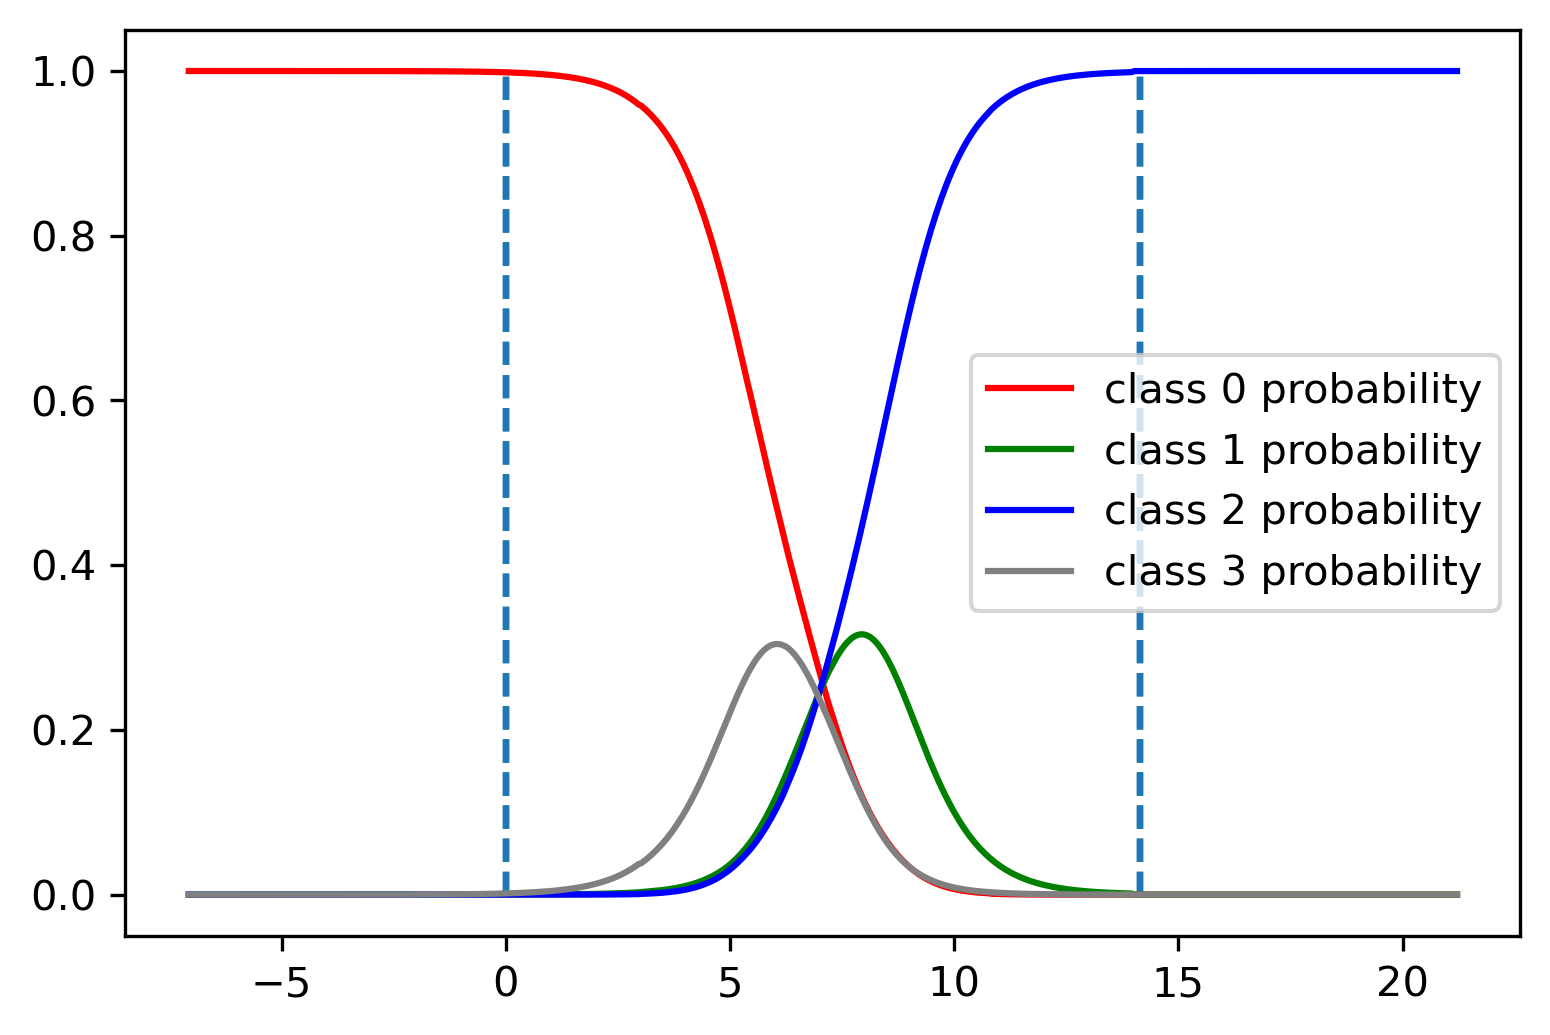

In [42]:
_ = plt.figure(figsize=(6,4), dpi=300)

for class_label,proba in zip([0,1,2,3],
                             [probas_linspace[:,0], probas_linspace[:,1], probas_linspace[:,2], probas_linspace[:,3]]):
    
    _ = plt.plot(np.linalg.norm(linspace-p0, axis=-1)*np.sign(np.dot((linspace-p0), (p1-p0))),
                 proba, color=colors[class_label],
                 label='class %d probability' % class_label)
    _ = plt.vlines([0.0, np.linalg.norm(p1-p0)], 0.0, 1.0, linestyles='dashed')
plt.legend()

## Сравните эти оценки вероятностей с теми, которые получены с помощью других моделей.

## Теперь посмотрим, как будет выглядеть результат при использовании радиально-базисного ядра

In [45]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2)

In [46]:
model = SVC(kernel='rbf', probability=True)

In [47]:
model.fit(xtrain, ytrain);

In [48]:
train_pred_sk = model.predict(xtrain)
train_proba_sk = model.predict_proba(xtrain)

In [49]:
(train_pred_sk == ytrain).mean()

0.9581875

Применим на тестовой выборке и проверим оценку качества

In [50]:
test_pred_sk = model.predict(xtest)
test_proba_sk = model.predict_proba(xtest)

In [51]:
(test_pred_sk == ytest).mean()

0.952

Данные довольно простые, хорошо разделимы линейно в исходном пространстве признаков, поэтому применение радиально-базисного ядра не сильно повысило качество

### Отобразим оценки вероятностей в пространстве признаков

In [52]:
x_test_mesh = np.concatenate([xmesh.ravel()[:,np.newaxis], ymesh.ravel()[:,np.newaxis]], axis=-1)
x_test_mesh.shape

(90000, 2)

In [53]:
labels_mesh = model.predict(x_test_mesh)
probas_mesh = model.predict_proba(x_test_mesh)

In [54]:
labels_mesh = labels_mesh.reshape(xmesh.shape)
probas_mesh = probas_mesh.reshape(list(xmesh.shape) + [4])

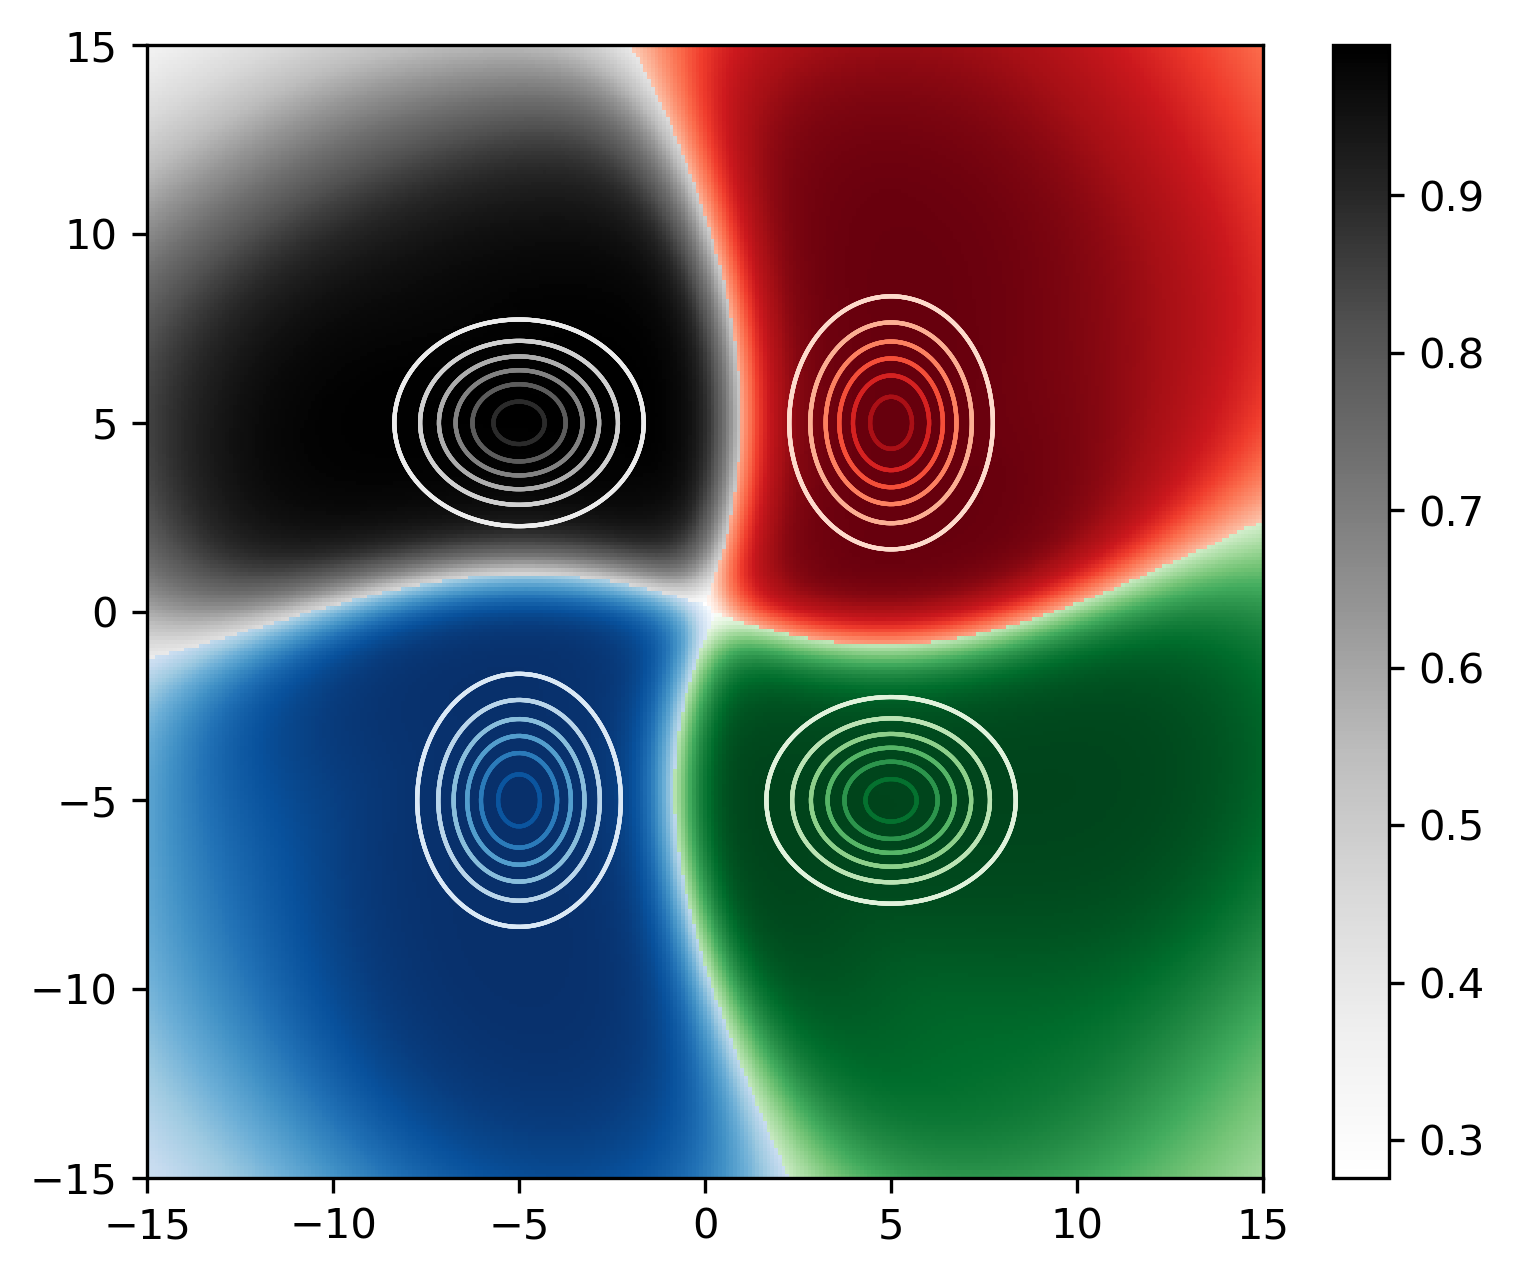

In [55]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)
for class_label,proba_mesh in zip([0,1,2,3],
                                  [probas_mesh[:,:,0], probas_mesh[:,:,1], probas_mesh[:,:,2], probas_mesh[:,:,3]]):
    pm = np.ma.array(proba_mesh)
    pm.mask = (labels_mesh != class_label)
    pcolormeshplot = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label])
    for class_label,norm in zip([0,1,2,3], [norm_class0, norm_class1, norm_class2, norm_class3]):
        cplot = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
plt.colorbar(pcolormeshplot)

### Отобразим вероятности классов в некоторых интересных сечениях

In [56]:
p0 = np.array([5, 5])
p1 = np.array([5, -5])
linspace = np.array([p0+k*((p1-p0)/100) for k in np.linspace(-50, 150, 500)])
linspace.shape

(500, 2)

In [57]:
probas_linspace = model.predict_proba(linspace)

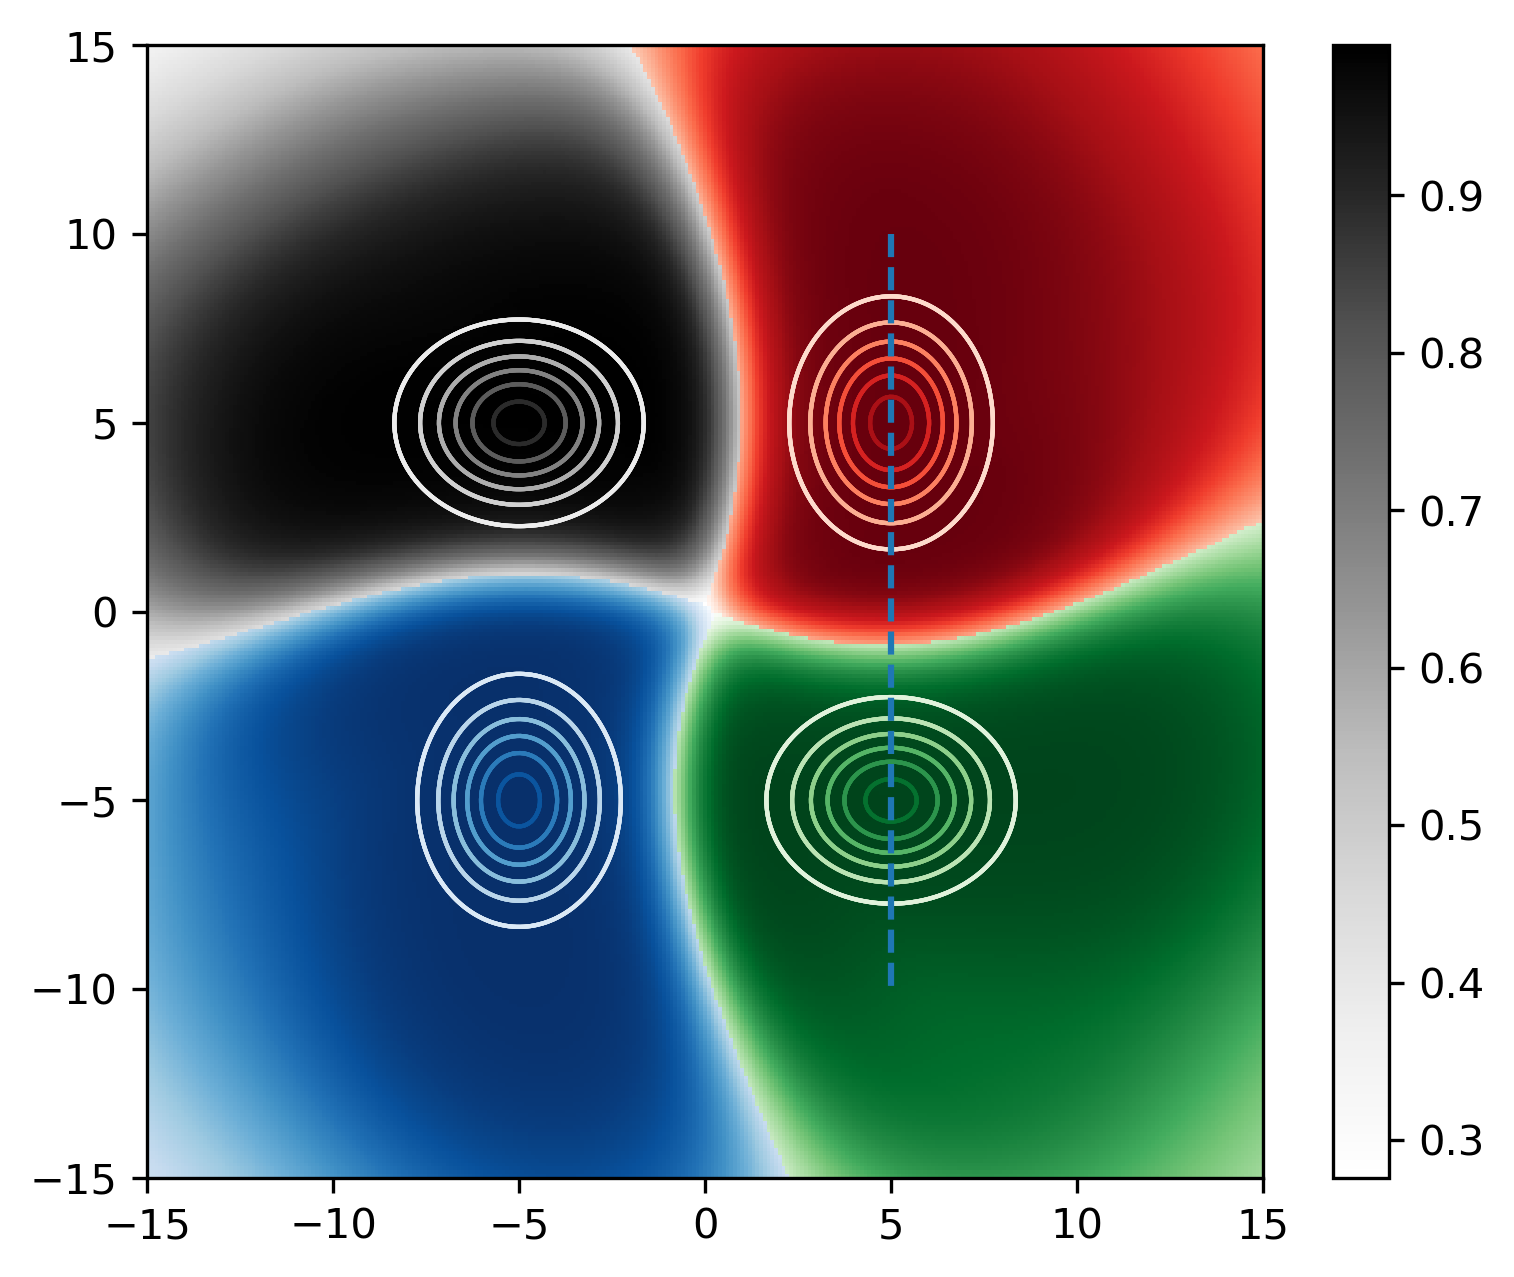

In [58]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)
for class_label,proba_mesh in zip([0,1,2,3],
                                  [probas_mesh[:,:,0], probas_mesh[:,:,1], probas_mesh[:,:,2], probas_mesh[:,:,3]]):
    pm = np.ma.array(proba_mesh)
    pm.mask = (labels_mesh != class_label)
    pcolormeshplot = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label])
    for class_label,norm in zip([0,1,2,3], [norm_class0, norm_class1, norm_class2, norm_class3]):
        cplot = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
_ = plt.plot(linspace[:,0], linspace[:,1], '--')

plt.colorbar(pcolormeshplot)

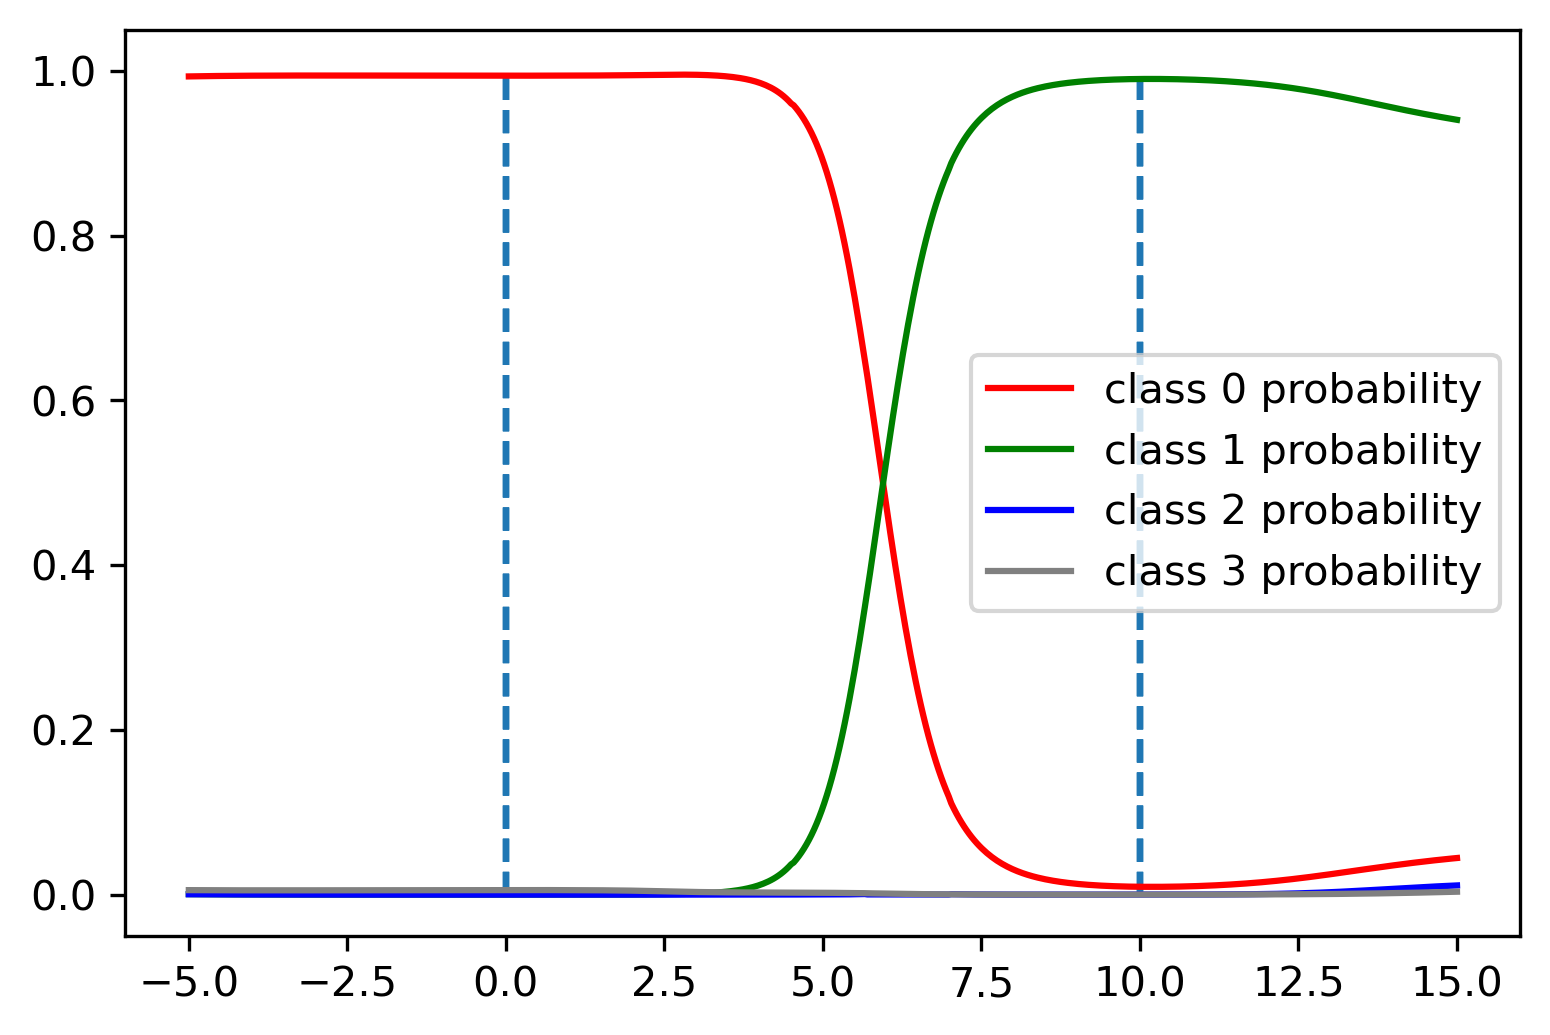

In [59]:
_ = plt.figure(figsize=(6,4), dpi=300)

for class_label,proba in zip([0,1,2,3],
                             [probas_linspace[:,0], probas_linspace[:,1], probas_linspace[:,2], probas_linspace[:,3]]):
    
    _ = plt.plot(np.linalg.norm(linspace-p0, axis=-1)*np.sign(np.dot((linspace-p0), (p1-p0))),
                 proba, color=colors[class_label],
                 label='class %d probability' % class_label)
    _ = plt.vlines([0.0, np.linalg.norm(p1-p0)],
                   0.0, 1.0, linestyles='dashed')
plt.legend()

In [60]:
p0 = np.array([5, 5])
p1 = np.array([-5, -5])
linspace = np.array([p0+k*((p1-p0)/100) for k in np.linspace(-50, 150, 500)])
linspace.shape

(500, 2)

In [61]:
probas_linspace = model.predict_proba(linspace)

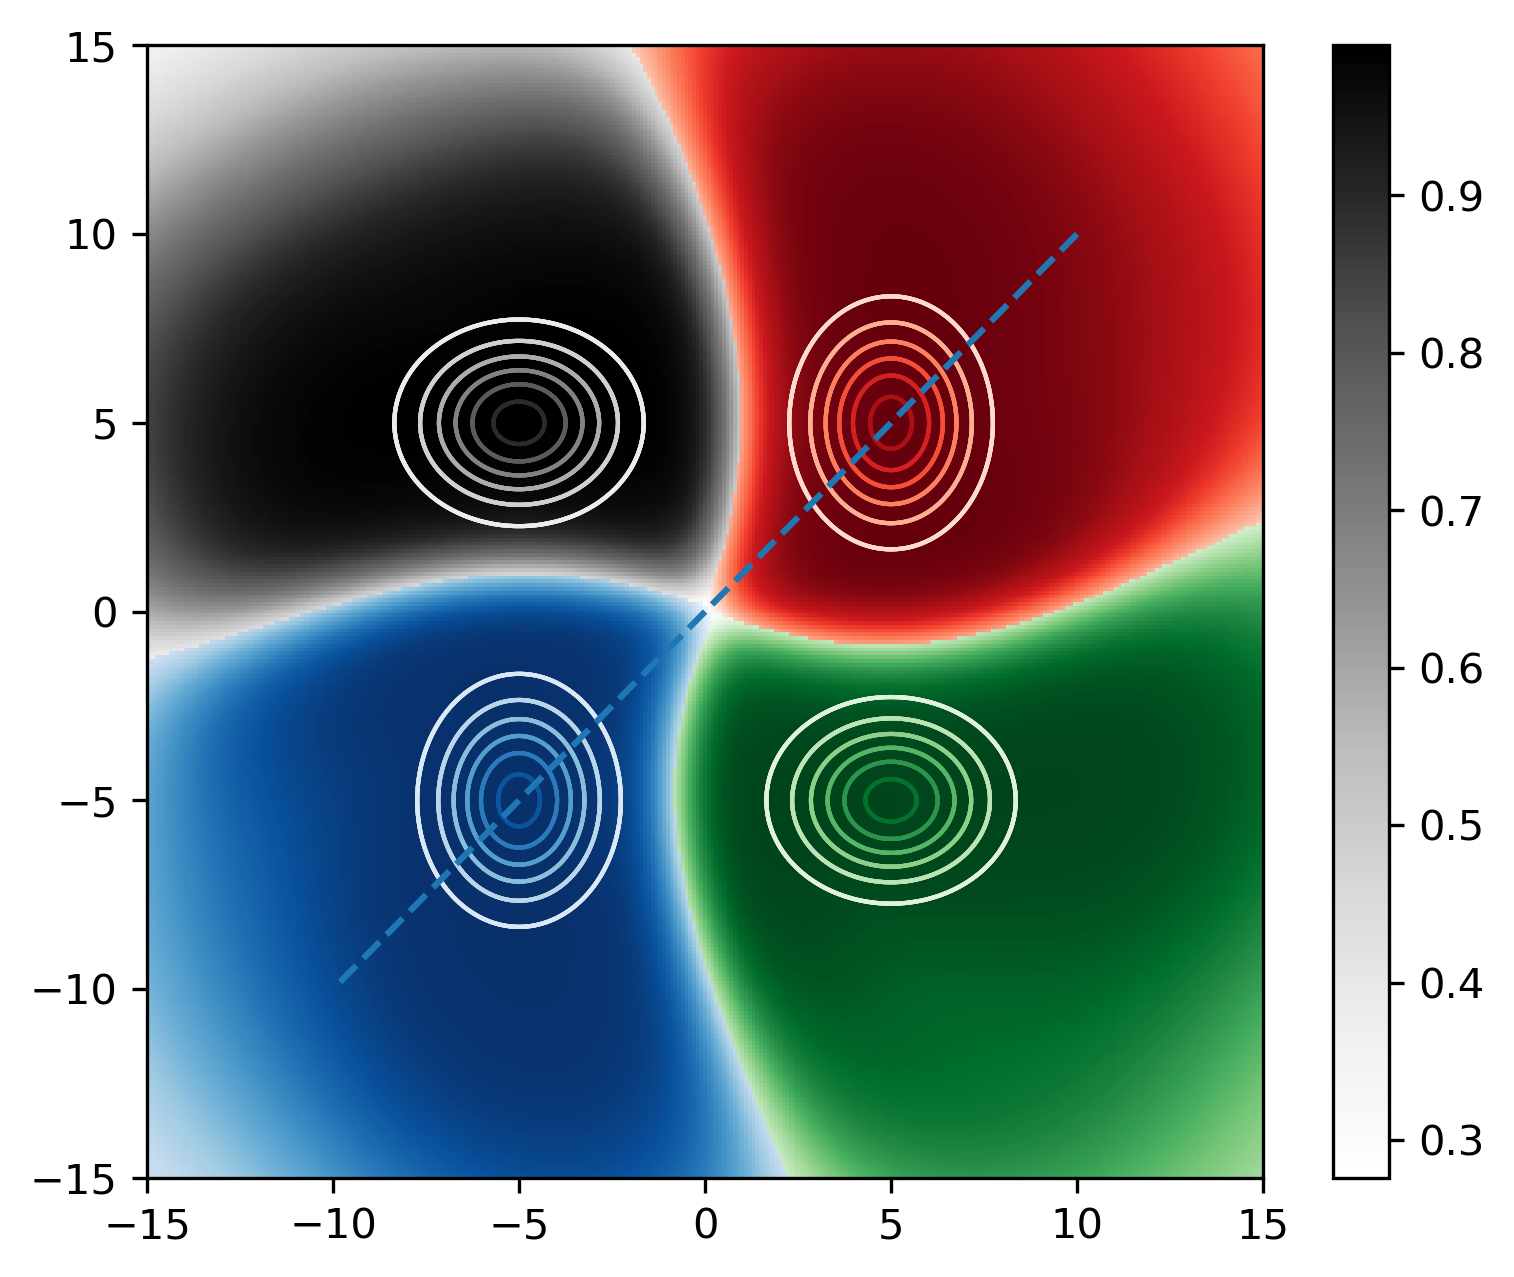

In [62]:
_ = plt.figure(figsize=(6,5), dpi=300)
_ = plt.xlim(-15, 15)
_ = plt.ylim(-15, 15)
for class_label,proba_mesh in zip([0,1,2,3],
                                  [probas_mesh[:,:,0], probas_mesh[:,:,1], probas_mesh[:,:,2], probas_mesh[:,:,3]]):
    pm = np.ma.array(proba_mesh)
    pm.mask = (labels_mesh != class_label)
    pcolormeshplot = plt.pcolormesh(xmesh, ymesh, pm, cmap=cmaps[class_label])
    for class_label,norm in zip([0,1,2,3], [norm_class0, norm_class1, norm_class2, norm_class3]):
        cplot = plt.contour(xmesh, ymesh, norm, cmap=cmaps[class_label], linewidths=1)
_ = plt.plot(linspace[:,0], linspace[:,1], '--')

plt.colorbar(pcolormeshplot)

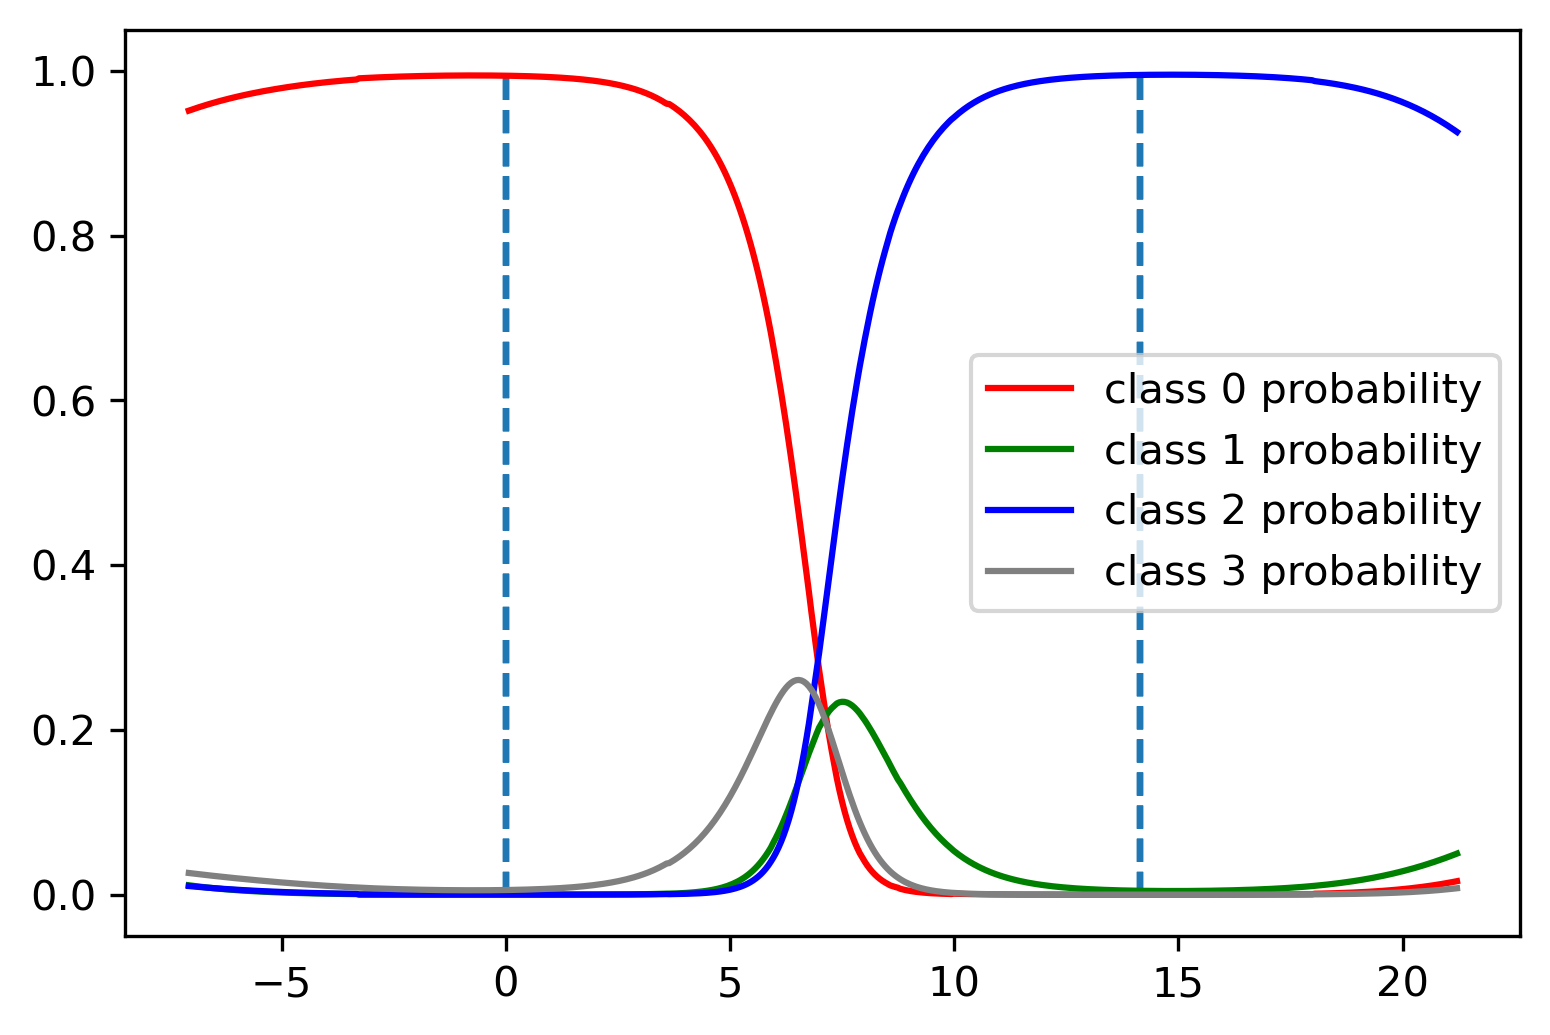

In [63]:
_ = plt.figure(figsize=(6,4), dpi=300)

for class_label,proba in zip([0,1,2,3],
                             [probas_linspace[:,0], probas_linspace[:,1], probas_linspace[:,2], probas_linspace[:,3]]):
    
    _ = plt.plot(np.linalg.norm(linspace-p0, axis=-1)*np.sign(np.dot((linspace-p0), (p1-p0))),
                 proba, color=colors[class_label],
                 label='class %d probability' % class_label)
    _ = plt.vlines([0.0, np.linalg.norm(p1-p0)], 0.0, 1.0, linestyles='dashed')
plt.legend()